In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
#
# Plot the histogram of the cycles between checkpoints
#
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from Color import *

# Matplotlib font configuration
from MatplotlibFonts import *
rcParams.update({"font.size": 13})

In [2]:
RESULT_DIR='../benchmarks/results'

In [3]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'opt-ratchet',
    'opt-baseline',
    'opt-all'
]
from BenchmarkConfiguration import *

In [4]:
# Dict with each benchmark
data = {}

def load_data(bench, config):
    global data
    
    # Add the benchmark if not there
    if bench not in data:
        data[bench] = {}
        
    # Add the config
    filename = RESULT_DIR+'/raw/checkpoint-frequency/'+bench+'-checkpointfreq-'+config+'.csv'
    print('Loading', filename)
    data[bench][config] = load_csv(filename)

def load_csv(filename):
    df = pd.read_csv(filename, names=['cycles', 'delta']).iloc[1:,:].reset_index() # ignore the startup gap (useless)
    df = df['delta'].to_frame()
    return df


In [5]:
for bench in Benchmarks:
    for config in Configurations:
        load_data(bench, config)
print('Done')

Loading ../benchmarks/results/raw/checkpoint-frequency/coremark-checkpointfreq-opt-ratchet.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/coremark-checkpointfreq-opt-baseline.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/coremark-checkpointfreq-opt-all.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/sha-checkpointfreq-opt-ratchet.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/sha-checkpointfreq-opt-baseline.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/sha-checkpointfreq-opt-all.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/crc-checkpointfreq-opt-ratchet.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/crc-checkpointfreq-opt-baseline.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/crc-checkpointfreq-opt-all.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/aes-checkpointfreq-opt-ratchet.csv
Loading ../benchmarks/results/raw/checkpoint-frequency/aes-checkpointfreq-opt-baseline.csv
Loa

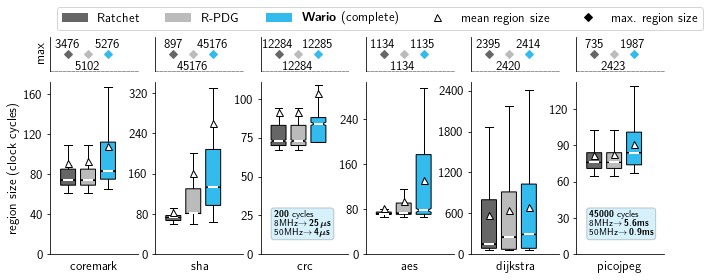

In [12]:

fig, axs = plt.subplots(2, 6, sharex=False, figsize=(11,4), gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.1)

group_spacing = 1
bar_spacing = 0.2
bar_width = 0.15

for gidx, bench in enumerate(data):
    #print('Analyzing bench', bench)
    for idx, config in enumerate(data[bench]):
        #print('  config:', config)
        pos = idx*bar_spacing
        #print('    pos:', pos)
        #data[bench][config].boxplot(notch=True, ax=ax, widths=bar_width, positions=[pos], showfliers=False, labels=['test']) 
        b = axs[1, gidx].boxplot(data[bench][config], notch=True, patch_artist=True,
                       widths=bar_width, positions=[pos], showfliers=False, 
                       labels=[ConfigurationNameMap[config]], showmeans=True,
                       boxprops=dict(facecolor=ConfigurationColorMap[config], linewidth=1),
                       medianprops=dict(color='white', linewidth=2),
                       meanprops=dict(color='black', markeredgecolor='black', markerfacecolor='white', markersize=7)
                      )

groups = len(data)
bar_per_group = len(data[next(iter(data))])

xlim = [-0.18, 0.7]
for gidx, bench in enumerate(data):
    axs[0, gidx].set_axis_on
    axs[0, gidx].axes.xaxis.set_visible(False)
    #axs[0, gidx].axes.yaxis.set_visible(False)
    axs[0, gidx].axes.yaxis.set_ticks([])
    axs[0, gidx].set_ylim(0,1)
    
    axs[1, gidx].set_xlim(xlim)
    axs[1, gidx].set_ylim(0, None)
    axs[1, gidx].spines['right'].set_visible(False)
    axs[1, gidx].spines['top'].set_visible(False)
    
    axs[0, gidx].set_xlim(xlim)
    axs[0, gidx].spines['right'].set_visible(False)
    axs[0, gidx].spines['top'].set_visible(False)
    axs[0, gidx].spines['bottom'].set_linestyle('--')
    axs[0, gidx].spines['bottom'].set_alpha(0.5)
    
    #pos = (bar_per_group-1)/2*bar_spacing
    pos = (xlim[0]+xlim[1])/2
    xticks = []
    xlabels = []
    xticks.append(pos)
    xlabels.append(bench)
    
    axs[1, gidx].set_xticks(xticks)
    axs[1, gidx].set_xticklabels(xlabels)
    axs[1, gidx].xaxis.set_ticks_position('none') 
    
    axs[1, gidx].yaxis.set_major_locator(plt.MaxNLocator(5))


# Build the outlier dots in axtop
dot_y = 0.5
for gidx, bench in enumerate(data):
    for idx, config in enumerate(data[bench]):
        pos = idx*bar_spacing
        maxval = data[bench][config]['delta'].max()
        #print('    pos:', pos)
        #print('    max:', maxval)
        if (idx % 2) == 0: 
            ytext = 10
        else: 
            ytext = -12
    
        axs[0, gidx].plot([pos], [dot_y], 'D', color=ConfigurationColorMap[config])
        axs[0, gidx].annotate("{:d}".format(maxval), xy=(pos, dot_y),xytext=(0,ytext),
            xycoords=('data'), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center')

#axs[0, 0].set_ylabel('max\nx$10^3$')
axs[0, 0].set_ylabel('max')
axs[1, 0].set_ylabel('region size (clock cycles)')

# Add the legend
handles = []
for config in Configurations:
    #print(configuration_color_map[config])
    handles.append(Patch(label=ConfigurationNameMap[config], facecolor=ConfigurationColorMap[config]))

# Add the markers to the legend
handles.append(Line2D([], [], markeredgecolor='black', markerfacecolor='white', markersize=7, 
                      marker='^', linestyle='None', label='mean region size'))
handles.append(Line2D([], [], markeredgecolor='black', markerfacecolor='black', markersize=6, 
                      marker='D', linestyle='None', label='max. region size'))

# Place the legend
axs[0, 0].legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", ncol=5)

# Add a single X-axis
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.xlabel('benchmark')

# Place a text box explaining the significance of the numbers
# Avg value explained
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  '$\\bf{200}$ cycles\n' + \
        '8MHz$\\rightarrow \\bf{25 \\, \\boldsymbol{\\mu}s}$\n' + \
        '50MHz$\\rightarrow \\bf{4 \\boldsymbol{\\mu}s}$'
plt.text(0.15, 0.1, text, transform=axs[1,2].transAxes, fontsize=9,
        verticalalignment='bottom', bbox=props)

# Max value explained
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  '$\\bf{45000}$ cycles\n' + \
        '8MHz$\\rightarrow\\bf{5.6ms}$\n' + \
        '50MHz$\\rightarrow\\bf{0.9ms}$'
plt.text(0.15, 0.1, text, transform=axs[1,5].transAxes, fontsize=9,
        verticalalignment='bottom', bbox=props)

# Show the plot
plt.show()

In [13]:
# Save the figure
#fig = bars.get_figure()
fig.savefig('plots/benchmark-region-size.pdf')

In [9]:
#
#
# TWO ROW VERSION
#
#


In [16]:

group_spacing = 1
bar_spacing = 0.2
bar_width = 0.15

def plotit(data, plot_type):
    plt.clf()
    fig, axs = plt.subplots(2, 3, sharex=False, figsize=(7,4), gridspec_kw={'height_ratios': [1, 5]})
    plt.subplots_adjust(hspace=0.1)

    for gidx, bench in enumerate(data):
        #print('Analyzing bench', bench)
        for idx, config in enumerate(data[bench]):
            #print('  config:', config)
            pos = idx*bar_spacing
            #print('    pos:', pos)
            #data[bench][config].boxplot(notch=True, ax=ax, widths=bar_width, positions=[pos], showfliers=False, labels=['test']) 
            b = axs[1, gidx].boxplot(data[bench][config], notch=True, patch_artist=True,
                           widths=bar_width, positions=[pos], showfliers=False, 
                           labels=[ConfigurationNameMap[config]], showmeans=True,
                           boxprops=dict(facecolor=ConfigurationColorMap[config], linewidth=1),
                           medianprops=dict(color='white', linewidth=2),
                           meanprops=dict(color='black', markeredgecolor='black', markerfacecolor='white', markersize=7)
                          )

    groups = len(data)
    bar_per_group = len(data[next(iter(data))])

    xlim = [-0.18, 0.7]
    for gidx, bench in enumerate(data):
        axs[0, gidx].set_axis_on
        axs[0, gidx].axes.xaxis.set_visible(False)
        #axs[0, gidx].axes.yaxis.set_visible(False)
        axs[0, gidx].axes.yaxis.set_ticks([])
        axs[0, gidx].set_ylim(0,1)

        axs[1, gidx].set_xlim(xlim)
        axs[1, gidx].set_ylim(0, None)
        axs[1, gidx].spines['right'].set_visible(False)
        axs[1, gidx].spines['top'].set_visible(False)

        axs[0, gidx].set_xlim(xlim)
        axs[0, gidx].spines['right'].set_visible(False)
        axs[0, gidx].spines['top'].set_visible(False)
        axs[0, gidx].spines['bottom'].set_linestyle('--')
        axs[0, gidx].spines['bottom'].set_alpha(0.5)

        #pos = (bar_per_group-1)/2*bar_spacing
        pos = (xlim[0]+xlim[1])/2
        xticks = []
        xlabels = []
        xticks.append(pos)
        xlabels.append(bench)

        axs[1, gidx].set_xticks(xticks)
        axs[1, gidx].set_xticklabels(xlabels)
        axs[1, gidx].xaxis.set_ticks_position('none') 

        axs[1, gidx].yaxis.set_major_locator(plt.MaxNLocator(5))


    # Build the outlier dots in axtop
    dot_y = 0.5
    for gidx, bench in enumerate(data):
        for idx, config in enumerate(data[bench]):
            pos = idx*bar_spacing
            maxval = data[bench][config]['delta'].max()
            #print('    pos:', pos)
            #print('    max:', maxval)
            if (idx % 2) == 0: 
                ytext = 10
            else: 
                ytext = -12

            axs[0, gidx].plot([pos], [dot_y], 'D', color=ConfigurationColorMap[config])
            axs[0, gidx].annotate("{:d}".format(maxval), xy=(pos, dot_y),xytext=(0,ytext),
                xycoords=('data'), textcoords='offset points',
                horizontalalignment='center', verticalalignment='center')

    #axs[0, 0].set_ylabel('max\nx$10^3$')
    axs[0, 0].set_ylabel('max')
    axs[1, 0].set_ylabel('idempotent region size (cycles)')

    # Add a single X-axis
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    #plt.xlabel('benchmark')

    if plot_type == 'top':
        # Place a text box explaining the significance of the numbers
        # Avg value explained
        props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
        text =  '$\\bf{200}$ cycles\n' + \
                '8MHz$\\rightarrow \\bf{25 \\, \\boldsymbol{\\mu}s}$\n' + \
                '50MHz$\\rightarrow \\bf{4 \\boldsymbol{\\mu}s}$'
        plt.text(0.15, 0.1, text, transform=axs[1,2].transAxes, fontsize=13,
                verticalalignment='bottom', bbox=props)
        
        # Place the legend (only on the top)
        
        # Add the legend
        handles = []
        for config in Configurations:
            #print(configuration_color_map[config])
            handles.append(Patch(label=ConfigurationNameMap[config], facecolor=ConfigurationColorMap[config]))

        # Add the markers to the legend
        # Spacer legend
        handles.append(Line2D([], [], markeredgecolor='white', markerfacecolor='white', markersize=7, 
                      marker=None, linestyle='None', label=''))
            
        handles.append(Line2D([], [], markeredgecolor='black', markerfacecolor='white', markersize=7, 
                              marker='^', linestyle='None', label='mean region size'))
        handles.append(Line2D([], [], markeredgecolor='black', markerfacecolor='black', markersize=6, 
                              marker='D', linestyle='None', label='max. region size'))
        axs[0, 0].legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", ncol=3, fontsize=11)
        
    if plot_type == 'bottom':
        # Max value explained
        props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
        text =  '$\\bf{45000}$ cycles\n' + \
                '8MHz$\\rightarrow\\bf{5.6ms}$\n' + \
                '50MHz$\\rightarrow\\bf{0.9ms}$'
        plt.text(0.15, 0.1, text, transform=axs[1,2].transAxes, fontsize=13,
                verticalalignment='bottom', bbox=props)

    # Show the plot
    plt.show()
    fig.savefig('plots/benchmark-region-size-'+plot_type+'.pdf')

data_top = {}
data_top['coremark'] = data['coremark']
data_top['sha'] = data['sha']
data_top['crc'] = data['crc']

data_bot = {}
data_bot['aes'] = data['aes']
data_bot['dijkstra'] = data['dijkstra']
data_bot['picojpeg'] = data['picojpeg']


<Figure size 432x288 with 0 Axes>

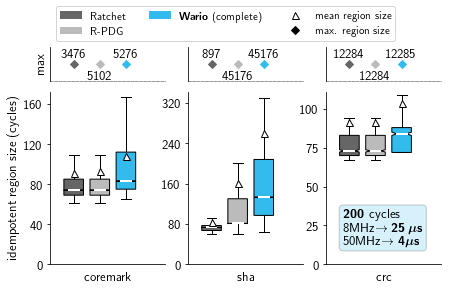

In [17]:
plotit(data_top, 'top')

<Figure size 432x288 with 0 Axes>

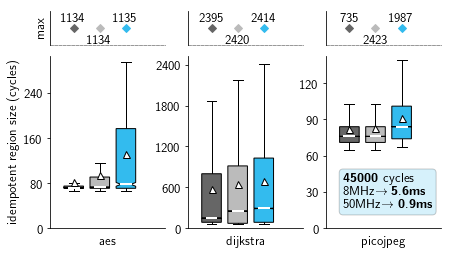

In [18]:
plotit(data_bot, 'bottom')